In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
data_folder = 'infoloss_data'

In [3]:
import time
t = time.time()

## Environment Setup (for Colab)

In [ ]:
from datetime import datetime

os.chdir('/content')
current_time = datetime.utcnow().isoformat().replace(':', '_')
os.makedirs(os.path.join(current_time))
os.chdir(f'./{current_time}')
WORKSPACE = 'anonify'

!git clone https://github.com/lng-ng/anonify.git

os.chdir(f'./{WORKSPACE}')

!pip install -r requirements.txt
!pip install -r expr_requirements.txt

## Download required data for the experiment

In [4]:
!python utils/download.py infoloss

## Run the experiment

In [7]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import utils.ncp as ncp
from utils.tree_utils import tree_fromdf


In [ ]:
SA_NAMES = ['hypertension', 'heart_disease', 'smoking_history', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
QID_NAMES = ['gender', 'age', 'bmi']

In [ ]:
# Constructing VGH for NCP calculations
trees = {}
for qid in QID_NAMES:
    treedf_path = os.path.join("utils","generalization_hierarchies", f"diabetes_hierarchy_{qid}.csv")
    treedf = pd.read_csv(treedf_path, sep=";", header=None, index_col=False)
    trees[qid] = tree_fromdf(treedf)
ncp_calculator = ncp.NCP(trees)

In [9]:
res_df = pd.DataFrame(columns=['Algorithm', 'k', 'NCP'])
ks = [50,100,150,200,250,300,350,400,450,500]
methods = ['arx', 'mondrian', 'oka']
for m in methods:
    for k in ks:
        data_path = os.path.join(f"{data_folder}", f"{m}", f"{k}")
        if m == "arx":
            data_path = os.path.join(data_path, "diabetes-anonymized.csv")
        else:
            data_path = os.path.join(data_path, f"diabetes_anonymized_{k}_0.csv")
        df = pd.read_csv(data_path,delimiter=',')
        ncp = 0
        grp = df.groupby(QID_NAMES).size().to_frame(name='size').reset_index()
        grp['ncp'] = grp.apply(lambda x: ncp_calculator.ncp(x) * x['size'], axis='columns')
        ncp += grp['ncp'].sum()
        ncp /= len(QID_NAMES)
        ncp /= len(df)
        ncp *= 100
        res_df.loc[len(res_df)] = [m, k, ncp]

In [10]:
res_df

,Algorithm,k,NCP
0,arx,50,10.996483
1,arx,100,11.176093
2,arx,150,11.529799
3,arx,200,11.961857
4,arx,250,12.260724
5,arx,300,12.697520
6,arx,350,12.851870
7,arx,400,13.057841
8,arx,450,13.357038
9,arx,500,13.535156


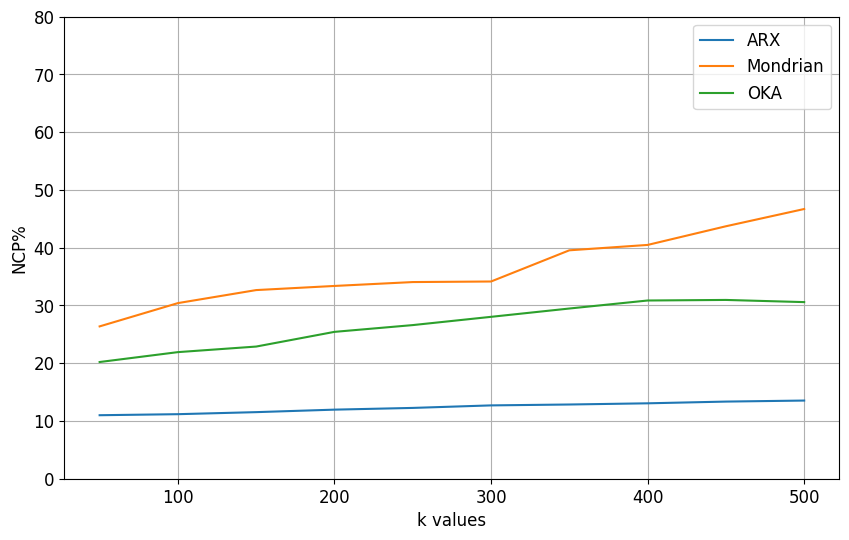

In [11]:
arx = res_df[res_df['Algorithm'] == 'arx'].sort_values(by='k', ascending=True)
mondrian = res_df[res_df['Algorithm'] == 'mondrian'].sort_values(by='k', ascending=True)
oka = res_df[res_df['Algorithm'] == 'oka'].sort_values(by='k', ascending=True)

# Data
data = [
    ("ARX", arx['k'], arx['NCP']),
    ("Mondrian", mondrian['k'], mondrian['NCP']),
    ("OKA", oka['k'], oka['NCP'])
]

# Create a line chart
plt.figure(figsize=(10, 6))

for algo, k_values, ncp_values in data:
    plt.plot(k_values, ncp_values, label=algo)

plt.xlabel("k values", fontsize=12)
plt.ylabel("NCP%", fontsize=12)
#plt.title("Comparison of Algorithms")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.ylim(0, 80)
plt.show()

In [12]:
# cleanup data folder
#import shutil
#shutil.rmtree(data_folder)

In [13]:
print(f"Time taken: {time.time() - t}")

Time taken: 55.41449952125549
